# Introduction


In this notebook, we implement [YOLOv4](https://arxiv.org/pdf/2004.10934.pdf) for training on your own dataset.

We also recommend reading our blog post on [Training YOLOv4 on custom data](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Configure our GPU environment on Google Colab
* Install the Darknet YOLOv4 training environment
* Download our custom dataset for YOLOv4 and set up directories
* Configure a custom YOLOv4 training config file for Darknet
* Train our custom YOLOv4 object detector
* Reload YOLOv4 trained weights and make inference on test images

When you are done you will have a custom detector that you can use. It will make inference like this:

#### ![Roboflow Workmark](https://i.imgur.com/L0n564N.png)

### **Reach out for support**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out!](https://roboflow.ai) 



#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Configuring cuDNN on Colab for YOLOv4



In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!nvidia-smi

Fri Jan  8 02:43:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Change the number depending on what GPU is listed above, under NVIDIA-SMI > Name.
# Tesla K80: 30
# Tesla P100: 60
# Tesla T4: 75
%env compute_capability=60

env: compute_capability=60


## STEP 1. Install cuDNN according to the current CUDA version
Colab added cuDNN as an inherent install - so you don't have to do a thing - major win




# Step 2: Installing Darknet for YOLOv4 on Colab




In [ ]:
%cd /content/
%rm -rf darknet

/content


In [ ]:
#we clone the fork of darknet maintained by roboflow
#small changes have been made to configure darknet for training
!git clone https://github.com/roboflow-ai/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 13289, done.
remote: Total 13289 (delta 0), reused 0 (delta 0), pack-reused 13289
Receiving objects: 100% (13289/13289), 12.13 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (9104/9104), done.


In [ ]:
%cd /content/darknet/
%rm Makefile

/content/darknet


In [ ]:
#colab occasionally shifts dependencies around, at the time of authorship, this Makefile works for building Darknet on Colab

%%writefile Makefile
GPU=1
CUDNN=1
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=1
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61]

OS := $(shell uname)

# Tesla V100
# ARCH= -gencode arch=compute_70,code=[sm_70,compute_70]

# GeForce RTX 2080 Ti, RTX 2080, RTX 2070, Quadro RTX 8000, Quadro RTX 6000, Quadro RTX 5000, Tesla T4, XNOR Tensor Cores
# ARCH= -gencode arch=compute_75,code=[sm_75,compute_75]

# Jetson XAVIER
# ARCH= -gencode arch=compute_72,code=[sm_72,compute_72]

# GTX 1080, GTX 1070, GTX 1060, GTX 1050, GTX 1030, Titan Xp, Tesla P40, Tesla P4
# ARCH= -gencode arch=compute_61,code=sm_61 -gencode arch=compute_61,code=compute_61

# GP100/Tesla P100 - DGX-1
# ARCH= -gencode arch=compute_60,code=sm_60

# For Jetson TX1, Tegra X1, DRIVE CX, DRIVE PX - uncomment:
# ARCH= -gencode arch=compute_53,code=[sm_53,compute_53]

# For Jetson Tx2 or Drive-PX2 uncomment:
# ARCH= -gencode arch=compute_62,code=[sm_62,compute_62]


VPATH=./src/
EXEC=darknet
OBJDIR=./obj/

ifeq ($(LIBSO), 1)
LIBNAMESO=libdarknet.so
APPNAMESO=uselib
endif

ifeq ($(USE_CPP), 1)
CC=g++
else
CC=gcc
endif

CPP=g++ -std=c++11
NVCC=nvcc
OPTS=-Ofast
LDFLAGS= -lm -pthread
COMMON= -Iinclude/ -I3rdparty/stb/include
CFLAGS=-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC

ifeq ($(DEBUG), 1)
#OPTS= -O0 -g
#OPTS= -Og -g
COMMON+= -DDEBUG
CFLAGS+= -DDEBUG
else
ifeq ($(AVX), 1)
CFLAGS+= -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a
endif
endif

CFLAGS+=$(OPTS)

ifneq (,$(findstring MSYS_NT,$(OS)))
LDFLAGS+=-lws2_32
endif

ifeq ($(OPENCV), 1)
COMMON+= -DOPENCV
CFLAGS+= -DOPENCV
LDFLAGS+= `pkg-config --libs opencv4 2> /dev/null || pkg-config --libs opencv`
COMMON+= `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv`
endif

ifeq ($(OPENMP), 1)
CFLAGS+= -fopenmp
LDFLAGS+= -lgomp
endif

ifeq ($(GPU), 1)
COMMON+= -DGPU -I/usr/local/cuda/include/
CFLAGS+= -DGPU
ifeq ($(OS),Darwin) #MAC
LDFLAGS+= -L/usr/local/cuda/lib -lcuda -lcudart -lcublas -lcurand
else
LDFLAGS+= -L/usr/local/cuda/lib64 -lcuda -lcudart -lcublas -lcurand
endif
endif

ifeq ($(CUDNN), 1)
COMMON+= -DCUDNN
ifeq ($(OS),Darwin) #MAC
CFLAGS+= -DCUDNN -I/usr/local/cuda/include
LDFLAGS+= -L/usr/local/cuda/lib -lcudnn
else
CFLAGS+= -DCUDNN -I/usr/local/cudnn/include
LDFLAGS+= -L/usr/local/cudnn/lib64 -lcudnn
endif
endif

ifeq ($(CUDNN_HALF), 1)
COMMON+= -DCUDNN_HALF
CFLAGS+= -DCUDNN_HALF
ARCH+= -gencode arch=compute_70,code=[sm_70,compute_70]
endif

ifeq ($(ZED_CAMERA), 1)
CFLAGS+= -DZED_STEREO -I/usr/local/zed/include
ifeq ($(ZED_CAMERA_v2_8), 1)
LDFLAGS+= -L/usr/local/zed/lib -lsl_core -lsl_input -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
else
LDFLAGS+= -L/usr/local/zed/lib -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
endif
endif

OBJ=image_opencv.o http_stream.o gemm.o utils.o dark_cuda.o convolutional_layer.o list.o image.o activations.o im2col.o col2im.o blas.o crop_layer.o dropout_layer.o maxpool_layer.o softmax_layer.o data.o matrix.o network.o connected_layer.o cost_layer.o parser.o option_list.o darknet.o detection_layer.o captcha.o route_layer.o writing.o box.o nightmare.o normalization_layer.o avgpool_layer.o coco.o dice.o yolo.o detector.o layer.o compare.o classifier.o local_layer.o swag.o shortcut_layer.o activation_layer.o rnn_layer.o gru_layer.o rnn.o rnn_vid.o crnn_layer.o demo.o tag.o cifar.o go.o batchnorm_layer.o art.o region_layer.o reorg_layer.o reorg_old_layer.o super.o voxel.o tree.o yolo_layer.o gaussian_yolo_layer.o upsample_layer.o lstm_layer.o conv_lstm_layer.o scale_channels_layer.o sam_layer.o
ifeq ($(GPU), 1)
LDFLAGS+= -lstdc++
OBJ+=convolutional_kernels.o activation_kernels.o im2col_kernels.o col2im_kernels.o blas_kernels.o crop_layer_kernels.o dropout_layer_kernels.o maxpool_layer_kernels.o network_kernels.o avgpool_layer_kernels.o
endif

OBJS = $(addprefix $(OBJDIR), $(OBJ))
DEPS = $(wildcard src/*.h) Makefile include/darknet.h

all: $(OBJDIR) backup results setchmod $(EXEC) $(LIBNAMESO) $(APPNAMESO)

ifeq ($(LIBSO), 1)
CFLAGS+= -fPIC

$(LIBNAMESO): $(OBJDIR) $(OBJS) include/yolo_v2_class.hpp src/yolo_v2_class.cpp
	$(CPP) -shared -std=c++11 -fvisibility=hidden -DLIB_EXPORTS $(COMMON) $(CFLAGS) $(OBJS) src/yolo_v2_class.cpp -o $@ $(LDFLAGS)

$(APPNAMESO): $(LIBNAMESO) include/yolo_v2_class.hpp src/yolo_console_dll.cpp
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -o $@ src/yolo_console_dll.cpp $(LDFLAGS) -L ./ -l:$(LIBNAMESO)
endif

$(EXEC): $(OBJS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) $^ -o $@ $(LDFLAGS)

$(OBJDIR)%.o: %.c $(DEPS)
	$(CC) $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cpp $(DEPS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cu $(DEPS)
	$(NVCC) $(ARCH) $(COMMON) --compiler-options "$(CFLAGS)" -c $< -o $@

$(OBJDIR):
	mkdir -p $(OBJDIR)
backup:
	mkdir -p backup
results:
	mkdir -p results
setchmod:
	chmod +x *.sh

.PHONY: clean

clean:
	rm -rf $(OBJS) $(EXEC) $(LIBNAMESO) $(APPNAMESO)

Writing Makefile


In [ ]:
#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
#note the Makefile above should work for you, if you need to tweak, try the below
%cd darknet/
#!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
#!sed -i 's/GPU=0/GPU=1/g' Makefile
#!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!#sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_${compute_capability},code=sm_${compute_capability}/g" Makefile
!make

[Errno 2] No such file or directory: 'darknet/'
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~


In [ ]:
from google.colab import drive
isMount=!df |grep /content/drive
if len(isMount)<1: drive.mount('/content/drive')


In [ ]:
#download the newly released yolov4 ConvNet weights
%cd /content/darknet

from os import getcwd
from os.path import join
from tensorflow.keras.utils import get_file

base_path="/content/drive/MyDrive/Lec_Capture/_data/yolo_v4"
url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137"
filename = join(base_path, "yolov4.conv.137")
get_file(filename, url,extract=True)

!cp /content/drive/MyDrive/Lec_Capture/_data/yolo_v4/yolov4.conv.137 ./

/content/darknet


# Set up Custom Dataset for YOLOv4

We'll use Roboflow to convert our dataset from any format to the YOLO Darknet format. 

1. To do so, create a free [Roboflow account](https://app.roboflow.ai).
2. Upload your images and their annotations (in any format: VOC XML, COCO JSON, TensorFlow CSV, etc).
3. Apply preprocessing and augmentation steps you may like. We recommend at least `auto-orient` and a `resize` to 416x416. Generate your dataset.
4. Export your dataset in the **YOLO Darknet format**.
5. Copy your download link, and paste it below.

See our [blog post](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) for greater detail.

In this example, I used the open source [BCCD Dataset](https://public.roboflow.ai/object-detection/bccd). (You can `fork` it to your Roboflow account to follow along.)

In [ ]:
#1. !cp /content/drive/MyDrive/Lec_Capture/_data/yolo_v4/HardHatSample.v3.darknet.zip ./
#    !unzip HardHatSample.v3.darknet.zip

#2.3. 복붙 !curl -L "https://app.roboflow.com/ds/59n8Pc2AtB?key=q2XmaWvulm" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# !curl -L "https://app.roboflow.com/ds/59n8Pc2AtB?key=q2XmaWvulm" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# !curl -L "https://app.roboflow.com/ds/59n8Pc2AtB?key=q2XmaWvulm" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://app.roboflow.com/ds/eNseimRbfC?key=u2Fx3pUDEd" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   890  100   890    0     0   1166      0 --:--:-- --:--:-- --:--:--  1164
100  171k  100  171k    0     0   111k      0  0:00:01  0:00:01 --:--:-- 37.4M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/KakaoTalk_Photo_2021-01-07-16-40-11_jpeg.rf.0540e8476876f68f4b291a2c17e8e2ce.jpg  
 extracting: test/KakaoTalk_Photo_2021-01-07-16-40-11_jpeg.rf.0540e8476876f68f4b291a2c17e8e2ce.txt  
 extracting: test/_darknet.labels    
   creating: train/
 extracting: train/KakaoTalk_Photo_2021-01-07-16-39-50_jpeg.rf.85602d56fac11ae911f1d46e0a943584.jpg  
 extracting: train/KakaoTalk_Photo_2021-01-07-16-39-50_jpeg.rf.85602d56fac11ae911f1d46e0a943584.txt  
 extracting: train/KakaoTalk_Photo_2021-01-07-16-39-59_jpeg.rf.d2d64e3b3c7fb941ab11acd831c8ca45.jpg  
 extracting: train/KakaoTalk_Photo_202

In [ ]:

# # #if you already have YOLO darknet format, you can skip this step
# %cd /content/darknet
# # !curl -L [YOUR LINK HERE] > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# !unzip /content/drive/MyDrive/Lec_Capture/_data/yolo_v4/HardHatSample.v3.darknet.zip



In [ ]:
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp train/*.jpg data/obj/
%cp valid/*.jpg data/obj/

%cp train/*.txt data/obj/
%cp valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 3\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

/content/darknet


# Write Custom Training Config for YOLOv4

In [ ]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_darknet.labels')
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-detector.cfg'): os.remove('./cfg/custom-yolov4-detector.cfg')


with open('./cfg/custom-yolov4-detector.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=64' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=24' + '\n')
  f.write('width=416' + '\n')
  f.write('height=416' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=0' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.001' + '\n')
  f.write('burn_in=1000' + '\n')
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  max_batches = num_classes*2000
  #max_batches = 2000
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = .8 * max_batches
  steps2 = .9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("file is written!")    




writing config for a custom YOLOv4 detector detecting number of classes: 1
file is written!


In [ ]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
%cat cfg/custom-yolov4-detector.cfg

[net]
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue = .1

learning_rate=0.001
burn_in=1000
max_batches=2000
policy=steps
steps=1600.0,1800.0
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-7

[convoluti

# Train Custom YOLOv4 Detector

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-detector.cfg yolov4.conv.137 -dont_show -map
#If you get CUDA out of memory adjust subdivisions above!
#adjust max batches down for shorter training above

Streaming output truncated to the last 5000 lines.
Loaded: 0.000042 seconds

 (next mAP calculation at 1000 iterations) 
 944: 0.292753, 0.553914 avg loss, 0.000794 rate, 3.400344 seconds, 45312 images, 0.706541 hours left
Loaded: 0.000046 seconds

 (next mAP calculation at 1000 iterations) 
 945: 0.493584, 0.547881 avg loss, 0.000797 rate, 3.345974 seconds, 45360 images, 0.709450 hours left
Loaded: 0.000037 seconds

 (next mAP calculation at 1000 iterations) 
 946: 0.496466, 0.542739 avg loss, 0.000801 rate, 3.296479 seconds, 45408 images, 0.712161 hours left
Loaded: 0.000057 seconds

 (next mAP calculation at 1000 iterations) 
 947: 0.384243, 0.526890 avg loss, 0.000804 rate, 3.695130 seconds, 45456 images, 0.714691 hours left
Loaded: 0.000060 seconds

 (next mAP calculation at 1000 iterations) 
 948: 0.953913, 0.569592 avg loss, 0.000808 rate, 3.589018 seconds, 45504 images, 0.718353 hours left
Loaded: 0.000062 seconds

 (next mAP calculation at 1000 iterations) 
 949: 0.721209, 0.5

# Infer Custom Objects with Saved YOLOv4 Weights

In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

custom-yolov4-detector_1000.weights  custom-yolov4-detector_final.weights
custom-yolov4-detector_2000.weights  custom-yolov4-detector_last.weights
custom-yolov4-detector_best.weights


In [ ]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [ ]:
!ls /content/darknet/train/KakaoTalk_Photo_2021-01-07-16-40-04_jpeg*

/content/darknet/train/KakaoTalk_Photo_2021-01-07-16-40-04_jpeg.rf.d1eddc84bc2a376015183264f5b05d31.jpg
/content/darknet/train/KakaoTalk_Photo_2021-01-07-16-40-04_jpeg.rf.d1eddc84bc2a376015183264f5b05d31.txt


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 700, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	          

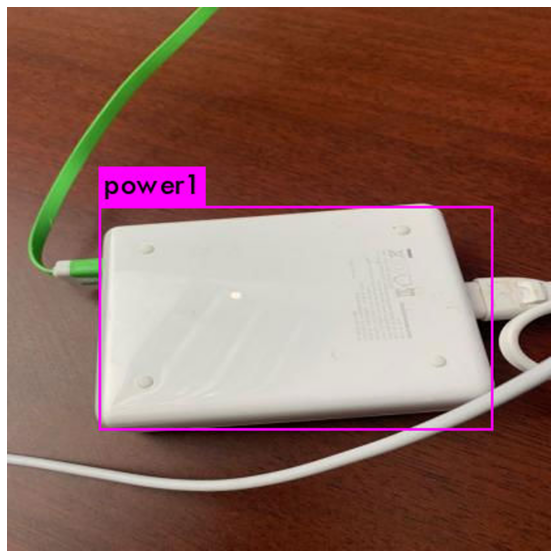

In [ ]:

#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
# !./darknet detect cfg/custom-yolov4-detector.cfg backup/custom-yolov4-detector_last.weights {img_path} -dont-show
img_path="/content/darknet/train/KakaoTalk_Photo_2021-01-07-16-40-04_jpeg.rf.d1eddc84bc2a376015183264f5b05d31.jpg"
!./darknet detect cfg/custom-yolov4-detector.cfg backup/custom-yolov4-detector_last.weights {img_path} -dont-show
imShow('predictions.jpg')

In [ ]:
!cp -r /content/darknet /content/drive/MyDrive/Lec_Capture/_data/